In [2]:
from google.colab import drive
import os
drive.mount("/content/drive/", force_remount = True)

os.chdir("/content/drive/MyDrive/Theja")

In [ ]:
!ls

data  Ensemble.ipynb  FeatExtr.ipynb


## Imports

In [ ]:
# Imports
import numpy as np
import cv2
import time
import imutils
from matplotlib import pyplot as plt
import glob

In [ ]:
def image_preprocessing(path):  

  img_bgr = cv2.imread(path)

  # bgr to rgb
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

  # Converting to grayscale
  img_just_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

  # Gaussian Blur
  ksize_w = 13
  ksize_h = 13
 
  img_first_gb = cv2.GaussianBlur(img_rgb, (ksize_w, ksize_h), 0, 0, cv2.BORDER_REPLICATE);

  # Dilate the image
  dilated_img = cv2.dilate(img_first_gb, np.ones((11, 11), np.uint8))

  # Converting to grayscale
  img_gray_operated = cv2.cvtColor(dilated_img, cv2.COLOR_BGR2GRAY)

  # closing:
  kernel_closing = np.ones((7, 7),np.uint8)
  img_closing = cv2.morphologyEx(img_gray_operated, cv2.MORPH_CLOSE, kernel_closing)

  # dilation:
  # add pixels to the boundaries of objects in an image
  kernel_dilation = np.ones((3, 3),np.uint8)
  img_dilation2 = cv2.dilate(img_closing, kernel_dilation, iterations = 1)

  # Canny
  edgesToFindImage = img_dilation2

  v = np.median(img_just_gray)
  #print(v)
  sigma = 0.33
  lower_thresh = int(max(0, (1.0 - sigma) * v))
  higher_thresh = int(min(255, (1.0 + sigma) * v))

  img_edges =  cv2.Canny(edgesToFindImage, lower_thresh, higher_thresh)

  kernel_dilation2 = np.ones((2, 2),np.uint8)
  img_dilation2 = cv2.dilate(img_edges, kernel_dilation, iterations = 2)
  dim = (50, 50)
  
  # resize image
  resized = cv2.resize(img_dilation2, dim, interpolation = cv2.INTER_AREA)

  return resized

In [ ]:
#scratch -0
#dent - 1
#rim_damage -2
#other_defect - 3
train_images = []
train_labels = []

In [ ]:
CLASSES = ['scratch','dent','rim_damage', 'other_defect']
for damage in CLASSES:

  for path in glob.iglob(f'data/train/{damage}/*'):
    
    image_new = image_preprocessing(path)
    train_images.append(image_new)
    train_labels.append(3)
    
print(len(train_images))
print(len(train_labels))

519
519


In [ ]:
for path in glob.iglob('data/train/other_defect/*'):
  
  image_new = image_preprocessing(path)
  train_images.append(image_new)
  train_labels.append(3)

In [ ]:
print(len(train_images))
print(len(train_labels))

35
35


In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

(519, 50, 50) (519,)


In [ ]:
#scratch -0
#dent - 1
#rim_damage -2
#other_defect - 3
test_images = []
test_labels = []

In [ ]:
for path in glob.iglob('data/test/other_defect/*'):

  image_new = image_preprocessing(path)
  test_images.append(image_new)
  test_labels.append(3)

In [ ]:
print(len(test_images))
print(len(test_labels))

225
225


In [ ]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(test_images.shape, test_labels.shape)

(225, 50, 50) (225,)


In [ ]:
train_images = train_images.reshape(519,2500)
test_images = test_images.reshape(225,2500)

In [ ]:
# compare standalone models for binary classification
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

>lr 0.512 (0.059)
>knn 0.443 (0.053)
>cart 0.511 (0.067)
>svm 0.615 (0.035)
>bayes 0.476 (0.088)


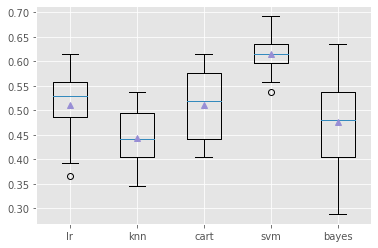

In [ ]:
# get a list of models
def get_models():
	'''
	Creates a dictionary of models to evaluate.

	Returns
	-------
	models: dictionary
	'''

	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	'''
	Evaluates a model with cross-validation.

	Parameters
	----------
	model: model instance

	X: input features

	y: input labels

	Returns
	-------
	scores: float
		Scores of the cross-validation.
	'''

	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

	return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
	
	scores = evaluate_model(model, train_images, train_labels)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Compare ensemble to each baseline classifier

>mlp 0.547 (0.060)
>lr 0.512 (0.059)
>knn 0.443 (0.053)
>cart 0.504 (0.059)
>svm 0.615 (0.035)
>bayes 0.476 (0.088)
>stacking 0.598 (0.047)


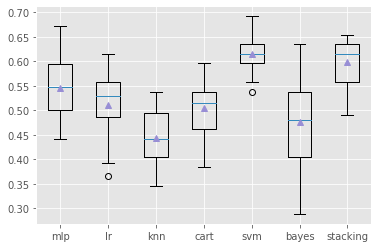

In [ ]:
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
 
# get a stacking ensemble of models
def get_stacking():

  # define the base models
  level0 = list()
  level0.append(('mlp', MLPClassifier()))
  level0.append(('lr', LogisticRegression()))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier()))
  level0.append(('svm', SVC()))
  level0.append(('bayes', GaussianNB()))

  # define meta learner model
  level1 = LogisticRegression()

  # define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

  return model

# get a list of models to evaluate
def get_models():

  models = dict()
  models['mlp'] = MLPClassifier()
  models['lr'] = LogisticRegression()
  models['knn'] = KNeighborsClassifier()
  models['cart'] = DecisionTreeClassifier()
  models['svm'] = SVC()
  models['bayes'] = GaussianNB()
  models['stacking'] = get_stacking()

  return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):

	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

	return scores
 

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():

	scores = evaluate_model(model, train_images, train_labels)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
  
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams

## Making a prediction with a stacking ensemble

In [ ]:
# make a prediction with a stacking ensemble
from sklearn.datasets import make_classification
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# define the base models
level0 = list()
level0.append(('mlp', MLPClassifier()))
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))

# define meta learner model
level1 = MLPClassifier()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# fit the model on all available data
model.fit(train_images, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/lo

StackingClassifier(cv=5,
                   estimators=[('mlp', MLPClassifier()),
                               ('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier()),
                               ('cart', DecisionTreeClassifier()),
                               ('svm', SVC()), ('bayes', GaussianNB())],
                   final_estimator=MLPClassifier())

## Predicting example

In [ ]:
y_pred_class = model.predict(test_images)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, y_pred_class))

0.6355555555555555


Classification Report
              precision    recall  f1-score   support

           0       0.52      0.80      0.63        82
           1       0.57      0.21      0.31        61
           2       0.90      0.94      0.92        67
           3       0.25      0.07      0.11        15

    accuracy                           0.64       225
   macro avg       0.56      0.51      0.49       225
weighted avg       0.63      0.64      0.59       225

Confusion matrix
[[66  9  5  2]
 [46 13  1  1]
 [ 4  0 63  0]
 [12  1  1  1]]


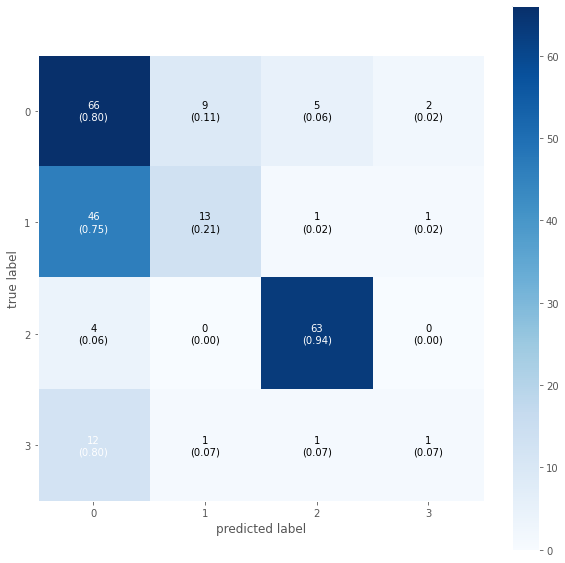

In [ ]:
print('Classification Report')
print(classification_report(test_labels, y_pred_class))
print("Confusion matrix")
CR=confusion_matrix(test_labels, y_pred_class)

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()